# The Timeseries Utilities
*TS utilities in Qiskit*

By: Jacob Cybulski<br>
Date: August 2023 - February 2024<br>
Aims: The goal of this notebook is to test a Time Series utilities.

In [1]:
%%html
<style>
table {float:left}
</style>

In [2]:
import sys
sys.path.append('.')
sys.path.append('..')
sys.path

['/home/jacob/Dropbox/Dev/Python/quantum_projects/ts/ts_denoise/utils',
 '/home/jacob/miniconda3/envs/qiskit-gpu/lib/python310.zip',
 '/home/jacob/miniconda3/envs/qiskit-gpu/lib/python3.10',
 '/home/jacob/miniconda3/envs/qiskit-gpu/lib/python3.10/lib-dynload',
 '',
 '/home/jacob/miniconda3/envs/qiskit-gpu/lib/python3.10/site-packages',
 '.',
 '..']

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pylab
import math
from IPython.display import clear_output
%matplotlib inline

from utils.Target import *
from utils.Window import *
from utils.Callback import *
from utils.TS import *

## Simple windows

In [4]:
y = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
y_wind_make(y, 4, 4)

array([[ 1,  2,  3,  4],
       [ 5,  6,  7,  8],
       [ 9, 10, 11, 12]])

In [5]:
Xy_wind_make(y, 4, 4, 2)

(array([[ 1,  2,  3,  4],
        [ 5,  6,  7,  8],
        [ 9, 10, 11, 12]]),
 array([[ 5,  6],
        [ 9, 10],
        [13, 14]]))

In [6]:
Xy_wind_split(y, 3, 2, 2, 0.75)

(array([[1, 2, 3],
        [3, 4, 5],
        [5, 6, 7],
        [7, 8, 9]]),
 array([[ 4,  5],
        [ 6,  7],
        [ 8,  9],
        [10, 11]]),
 array([[ 9, 10, 11],
        [11, 12, 13]]),
 array([[12, 13],
        [14, 15]]))

## TS settings

In [7]:
### Data settings
samples = 100
samples_hi_res = samples*2
split = 0.7

### Define the time series parameters
#   wind_size: sliding window size (which may be the same as number of qubits)
#   horizon:   the number of time events to look ahead (to forecast)
wind_size = 8 # tested with: 6(-), 8(+), 9(-) 10(++)
wind_step = 1
horizon = 1
scale = 1 # 2
pan = 0 # -1

## TS generation

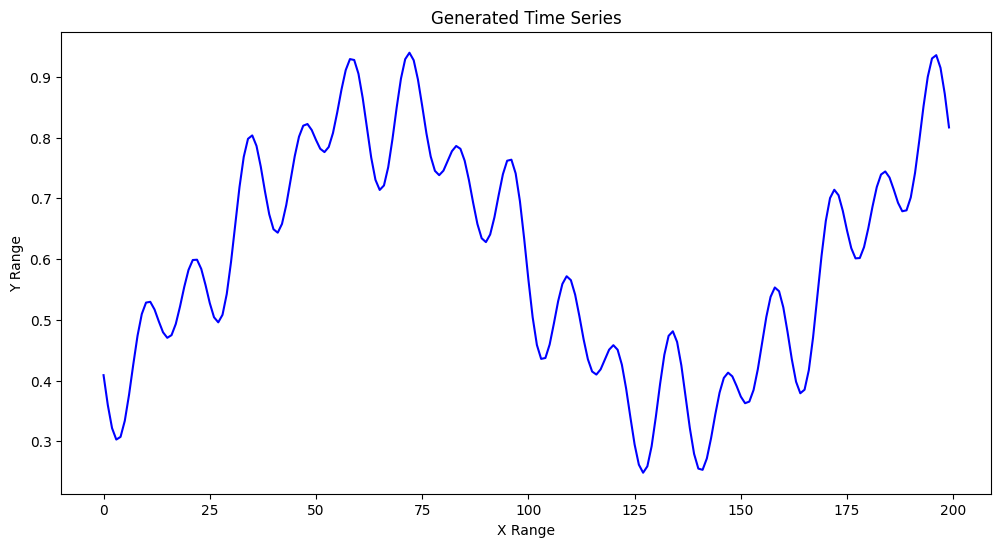

In [8]:
### Test series generation

# Generate data
fun_train = Target_3_sins()
sample_X, sample_y = \
    gen_ts(fun_train, samples_hi_res)

# Plot the original time series
plt.rcParams["figure.figsize"] = (12, 6)
plt.title('Generated Time Series')
plt.xlabel('X Range')
plt.ylabel('Y Range')
plt.plot(sample_X, sample_y, color='blue')
plt.show()

## Adding TS noise

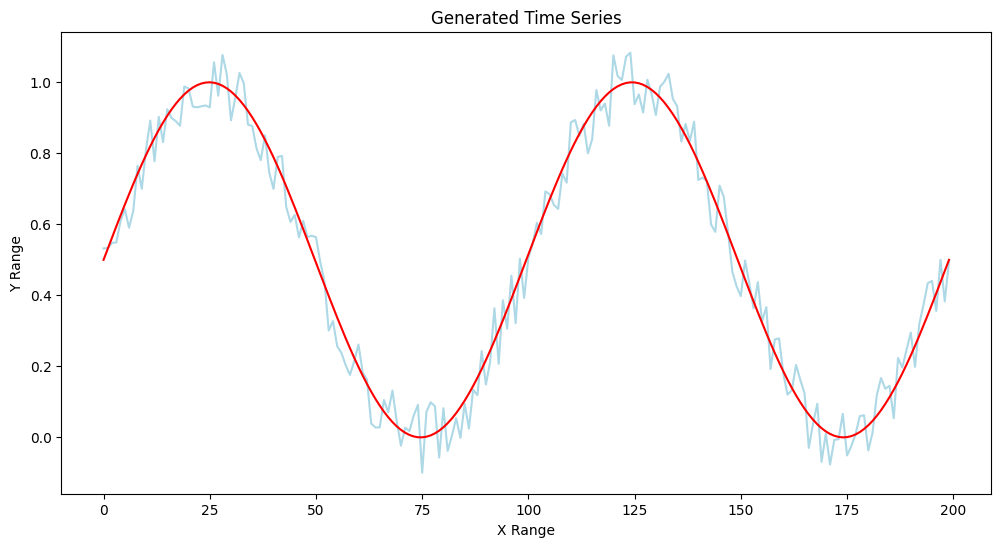

In [19]:
### Testing adding TS noise
fun_train = Target_sin()
sample_X, sample_y = \
    gen_ts(fun_train, samples_hi_res)
sample_noisy_X, sample_noisy_y = gen_noisy_ts(sample_X, sample_y, noise=0.1)

# Plot the original time series
plt.rcParams["figure.figsize"] = (12, 6)
plt.title('Generated Time Series')
plt.xlabel('X Range')
plt.ylabel('Y Range')
plt.plot(sample_noisy_X, sample_noisy_y, color='lightblue')
plt.plot(sample_noisy_X, sample_y, color='red')
plt.show()

## TS differencing

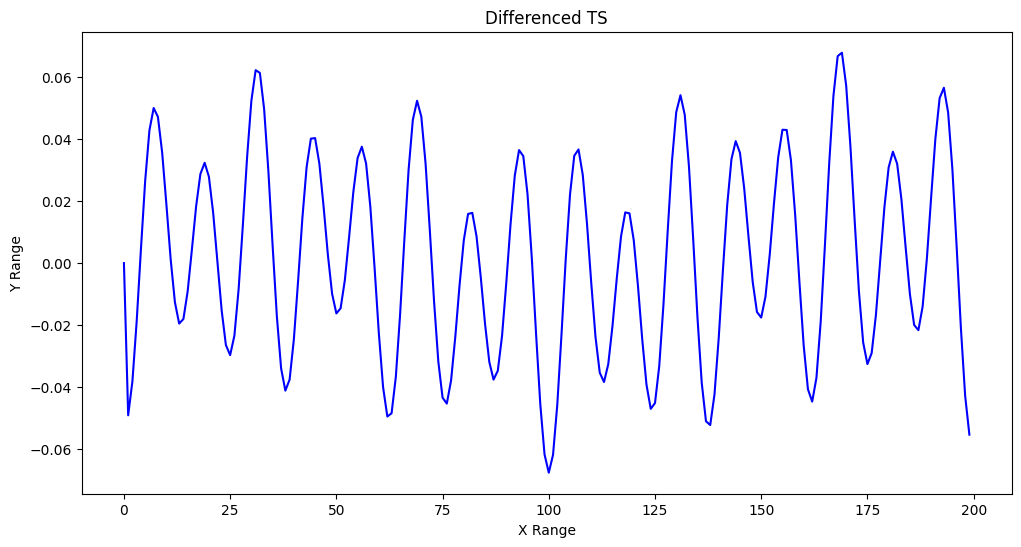

In [21]:
### Testing differencing
# Generate data
fun_train = Target_2_sins()
sample_X, sample_y = \
    gen_ts(fun_train, samples_hi_res)
_, sample_diff_y = \
    gen_diff_ts(sample_X, sample_y)

# Plot the differenced time series
plt.rcParams["figure.figsize"] = (12, 6)
plt.title('Differenced TS')
plt.xlabel('X Range')
plt.ylabel('Y Range')
plt.plot(sample_X, sample_diff_y, color='blue')
plt.show()

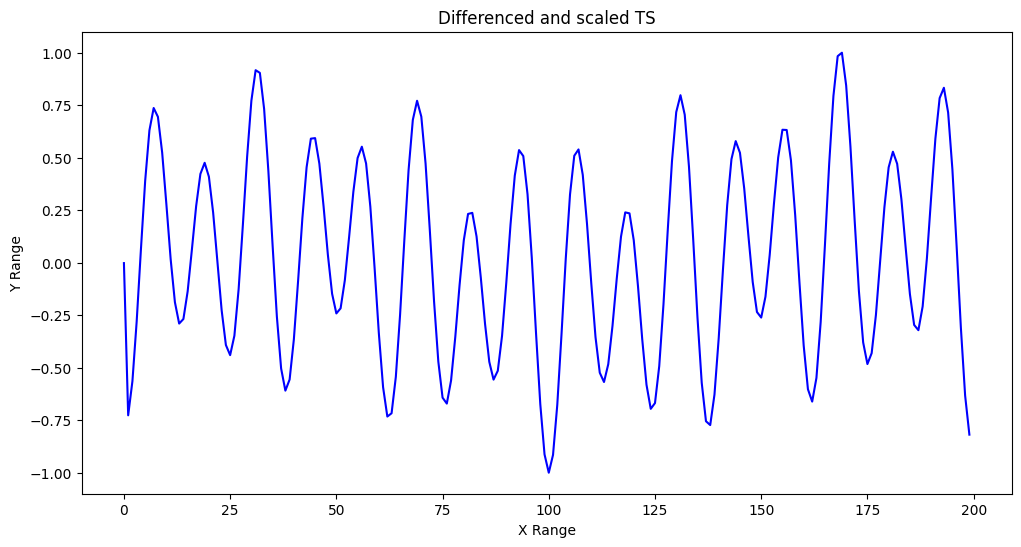

Start from:	(-0.06761610061105394, 0.06786840486260126) -> (-0.06761610061105394, 0.06786840486260126)


In [12]:
### Testing TS scaling

scaled_diff_y, old_min_y, old_max_y = gen_scale_ts(sample_diff_y, -1, 1)

# Plot the differenced time series
plt.rcParams["figure.figsize"] = (12, 6)
plt.title('Differenced and scaled TS')
plt.xlabel('X Range')
plt.ylabel('Y Range')
plt.plot(sample_X, scaled_diff_y, color='blue')
plt.show()

print(f'Start from:\t{(np.min(sample_diff_y), np.max(sample_diff_y))} -> {(old_min_y, old_max_y)}')

## TS plotting

In [13]:
### Plot source data
def qae_plot_source_data(
    X_train, y_train, X_valid, y_valid,
    add_markers=True,
    label_suffix=['', '', ''],
    xlabel='Range', ylabel='Target value (deltas)',
    title=f'Differenced TS Windows for Training and Validation',
    sel_wind=None):

    # Plot the original time series
    plt.rcParams["figure.figsize"] = (12, 6)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    # plt.xlim(lb, ub)

    # Plot target function
    plt.plot([xt[0] for xt in X_train], [y[0] for y in y_train], color='blue', label='Training')
    plt.plot([xv[0] for xv in X_valid], [y[0] for y in y_valid], color='red', label='Validation')
    if sel_wind != None:
        plt.plot(X_train[sel_wind], y_train[sel_wind], color='magenta', label='Window '+str(sel_wind))
    if add_markers:
        plt.plot([xt[0] for xt in X_train], [y[0] for y in y_train], marker='o', color='lightblue', linestyle='None')
        plt.plot([xv[0] for xv in X_valid], [y[0] for y in y_valid], marker='o', color='pink', linestyle='None')
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2),
              ncol=3, fancybox=True, shadow=True)
    plt.show()

## Windowed TS with options

In [27]:
### Calculates the total noise as a percentage of value range
def calculated_noise(windows_org, windows_noisy):
    noise_sum = 0
    points_no = 0
    hi_val = 0.0
    low_val = 0.0
    for wind_no in range(len(windows_org)):
        wind_org = windows_org[wind_no]
        wind_noisy = windows_noisy[wind_no]
        for val_no in range(len(wind_org)):
            points_no += 1
            noise_sum += np.abs(wind_noisy[val_no]-wind_org[val_no])
            hi_val = max(wind_noisy[val_no], hi_val)
            low_val = min(wind_noisy[val_no], low_val)
    noise = (noise_sum / points_no)/(hi_val - low_val)
    return noise, noise_sum, points_no

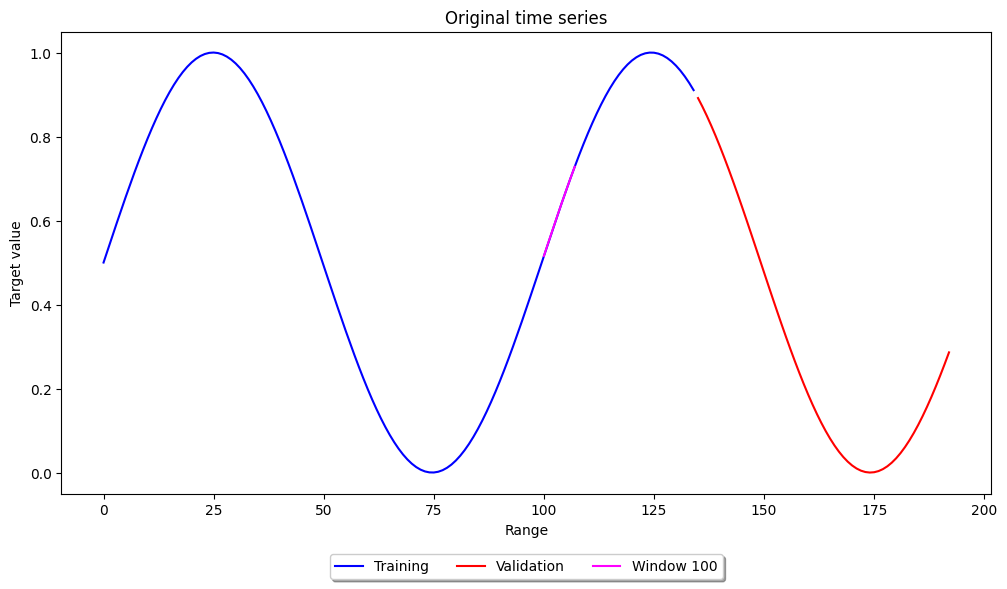

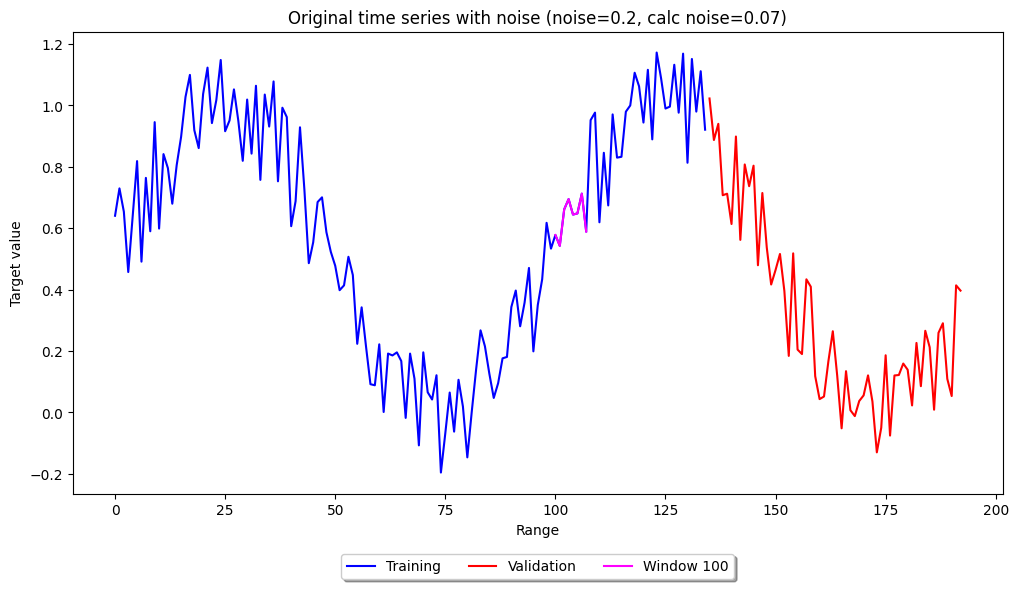

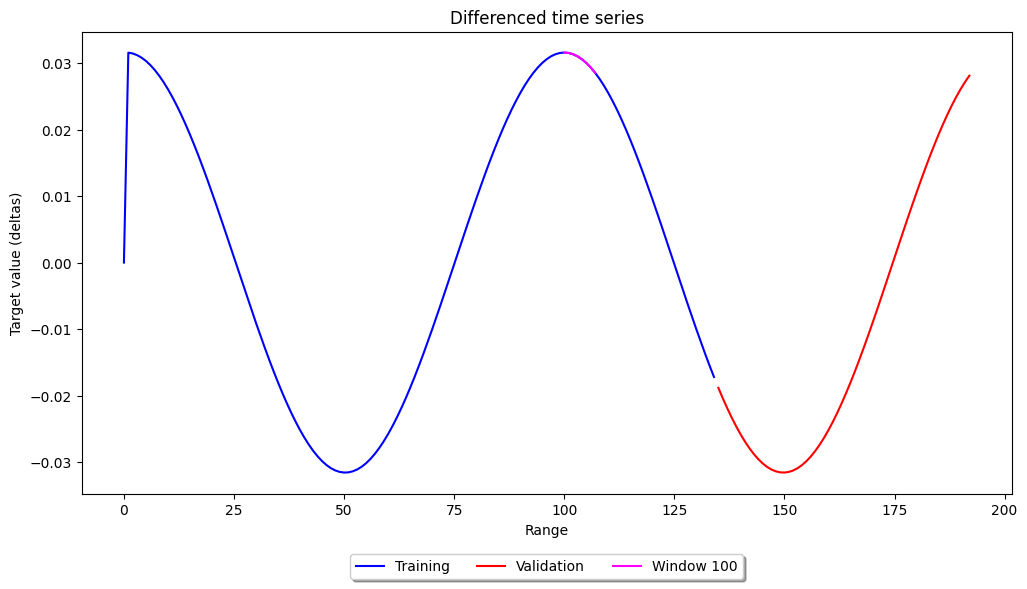

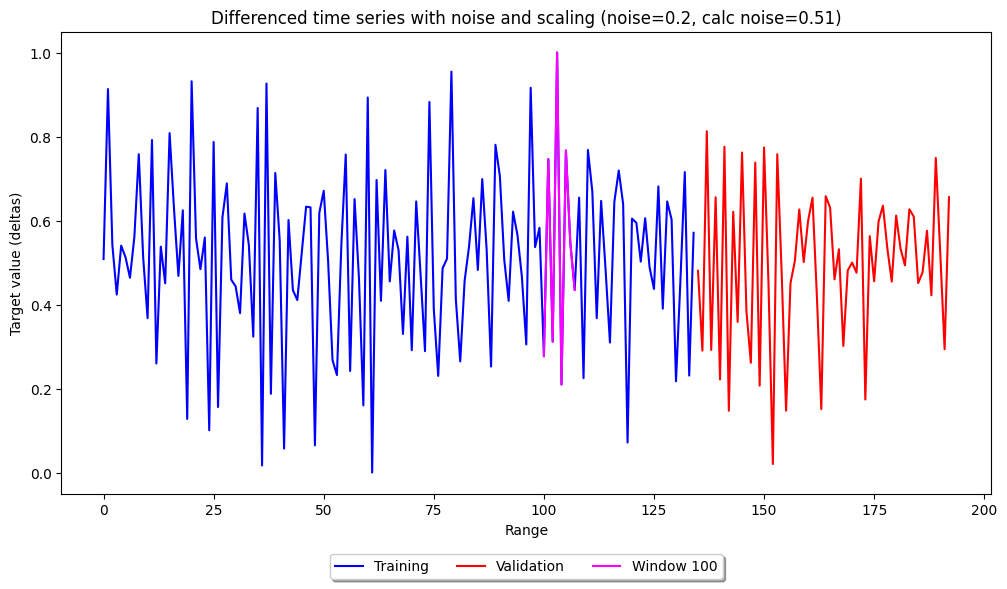

Y min: (0.0, 0.020368369706657924), Y max: (1.0, 0.8452772906266608)


In [29]:
### Testing TS windows generation with options

### Select a target class and its parameters (see: utils.py), e.g.
#   Target_sin() # Target_2_sins() # Target_poly() # Target_poly_3()
#   Target_line() # Target_line(slope=0.5, intercept=0.2, xmin=0, xmax=1.5)
#   Target_trig_trend() # Target_jitter()
#   Target_beer() # Target_beer(pt_from=104, pt_to=156)

# Create TSs of different properties
fun_train = Target_sin()
noise = 0.2

X_train_org, y_train_org, X_valid_org, y_valid_org = \
    gen_ts_windows(fun_train, samples_hi_res, split, wind_size, wind_step, differencing=False)

X_train_org_noisy, y_train_org_noisy, X_valid_org_noisy, y_valid_org_noisy = \
    gen_ts_windows(fun_train, samples_hi_res, split, wind_size, wind_step, differencing=False, noise=noise)

X_train_ts, y_train_ts, X_valid_ts, y_valid_ts = \
    gen_ts_windows(fun_train, samples_hi_res, split, wind_size, wind_step, differencing=True)

X_train_noisy, y_train_noisy, X_valid_noisy, y_valid_noisy = \
    gen_ts_windows(fun_train, samples_hi_res, split, wind_size, wind_step, differencing=True, noise=noise, scale=(0, 1))

# Calculate noise
calc_org_noise, _, _ = calculated_noise(y_train_org, y_train_org_noisy)
calc_diff_noise, _, _ = calculated_noise(y_train_ts, y_train_noisy)

# Plot results
qae_plot_source_data(X_train_org, y_train_org, X_valid_org, y_valid_org, sel_wind=100, add_markers=False,
                    title=f'Original time series', ylabel='Target value')
qae_plot_source_data(X_train_org_noisy, y_train_org_noisy, X_valid_org_noisy, y_valid_org_noisy, sel_wind=100, add_markers=False,
                    title=f'Original time series with noise (noise={np.round(noise, 2)}, calc noise={np.round(calc_org_noise, 2)})', ylabel='Target value')
qae_plot_source_data(X_train_ts, y_train_ts, X_valid_ts, y_valid_ts, sel_wind=100, add_markers=False,
                    title=f'Differenced time series')
qae_plot_source_data(X_train_noisy, y_train_noisy, X_valid_noisy, y_valid_noisy, sel_wind=100, add_markers=False,
                    title=f'Differenced time series with noise and scaling (noise={np.round(noise, 2)}, calc noise={np.round(calc_diff_noise, 2)})')

print(f'Y min: {(np.min(y_train_noisy), np.min(y_valid_noisy))}, Y max: {(np.max(y_train_noisy), np.max(y_valid_noisy))}')

## Software in use

In [15]:
import inspect
import utils.TS as TS
import utils.Target as Target
import utils.Window as Window
import utils.Callback as Callback

def is_mod_function(mod, func):
    ' checks that func is a function defined in module mod '
    return inspect.isfunction(func) and inspect.getmodule(func) == mod

def list_functions(mod):
    ' list of functions defined in module mod '
    fl = []
    for func in mod.__dict__.values():
        if is_mod_function(mod, func):
            fl.append(func.__name__)
        elif inspect.isclass(func):
            fl.append(func.__name__)
    return fl

def print_functions(mod):
    print(f'{mod.__name__}:\n\t{", ".join(list_functions(mod))}')

print()
print_functions(Callback)
print_functions(Window)
print_functions(TS)
print_functions(Target)


utils.Callback:
	Callback
utils.Window:
	ts_wind_make, ts_wind_flatten, ts_wind_split, y_wind_make, Xy_wind_make, Xy_wind_split
utils.TS:
	gen_ts, gen_noisy_ts, gen_diff_ts, gen_scale_ts, gen_ts_windows
utils.Target:
	Target, Target_sin, Target_2_sins, Target_3_sins, Target_poly, Target_poly_3, Target_line, Target_trig_trend, Target_jitter, Target_beer, Target_csv_file
